#### RelationPressureCurrent
圧力勾配がdepressionに対してどれだけの効果があるのかを探る

とりあえず...
* diamagcurrentとdeltaBcurrentの関係をとる
  * とりあえず相関をとってみる？
    * 単純に相関をとるだけでは，電流が0に近い値をとるときの結果に引っ張られすぎる   
    * この部分の効果を無視するにはどうすべきか...
  * 上下のピークの位置，強さの関係を探ってみる？
* 圧力勾配のみを考察する
  * 空間的な構造？
  * 発生時の太陽風条件？
    * どの点を代表に？
* 高温の場合は反磁性電流が少し変？

In [27]:
import MDUS
from MDUS import Analysis

from scipy.signal import coherence
import scipy.stats as stats

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
temperature = pd.read_pickle('./data/other/TemperatureAverage.pkl')

dip_over_25 = temperature.query('type == "dip" & T > 25').index.values
dip_under_25 = temperature.query('type == "dip" & T < 25').index.values
ns_over_25 = temperature.query('type == "ns" & T > 25').index.values
ns_under_25 = temperature.query('type == "ns" & T < 25').index.values
none_over_25 = temperature.query('type == "none" & T > 25').index.values
none_under_25 = temperature.query('type == "none" & T < 25').index.values

In [10]:
MDUS.dip

,start,end
orbit,,
18,2011-03-27 02:12:50,2011-03-27 02:24:20
28,2011-04-01 02:56:10,2011-04-01 03:13:40
41,2011-04-07 15:53:50,2011-04-07 16:05:30
42,2011-04-08 03:57:50,2011-04-08 04:09:30
43,2011-04-08 16:01:50,2011-04-08 16:12:10
...,...,...
4043,2015-04-09 05:45:50,2015-04-09 05:57:50
4048,2015-04-10 23:26:30,2015-04-10 23:37:30
4051,2015-04-12 00:30:20,2015-04-12 00:40:10


In [25]:
# 反磁性電流の最大値，最小値とrotB電流の最大値，最小値の関係
# 格納するリスト
dip_over_25_diamag_max = []
dip_over_25_diamag_min = []
dip_under_25_diamag_max = []
dip_under_25_diamag_min = []
ns_over_25_diamag_max = []
ns_over_25_diamag_min = []
ns_under_25_diamag_max = []
ns_under_25_diamag_min = []
none_over_25_diamag_max = []
none_over_25_diamag_min = []
none_under_25_diamag_max = []
none_under_25_diamag_min = []
dip_over_25_rotB_max = []
dip_over_25_rotB_min = []
dip_under_25_rotB_max = []
dip_under_25_rotB_min = []
ns_over_25_rotB_max = []
ns_over_25_rotB_min = []
ns_under_25_rotB_max = []
ns_under_25_rotB_min = []
none_over_25_rotB_max = []
none_over_25_rotB_min = []
none_under_25_rotB_max = []
none_under_25_rotB_min = []

# 計算
for i in temperature.itertuples():
    orbit = i.Index
    # dataの生成
    data = MDUS.Datas()
    data.Input(orbit=orbit,inputdata=["scan"])
    if data.scan.value is None:
        continue
    data.scan.DataIntegration()
    data.scan.NTP()
    data.scan.CalcKTH22(rc=False,ns=False)
    data.scan.rotBCurrent()
    data.scan.DiamagCurrent()
    data.scan.MoveAverage(window=16)
    if orbit in MDUS.dip.index:
        ds = MDUS.dip.query('index == @orbit')['start'].values[0]
        de = MDUS.dip.query('index == @orbit')['end'].values[0]
    else:
        data.scan.MCOOR()
        dt = np.abs(data.scan.value.query("X_MSO <= 0"))["MLAT"].idxmin()
        ds = dt - pd.Timedelta("5min")   
        de = dt + pd.Timedelta("5min")

    # 反磁性電流の最大値，最小値
    if orbit in dip_over_25:
        dip_over_25_diamag_max.append(data.scan.value.query('@ds <= index <= @de')['Jy_diamag'].max())
        dip_over_25_diamag_min.append(data.scan.value.query('@ds <= index <= @de')['Jy_diamag'].min())
        dip_over_25_rotB_max.append(data.scan.value.query('@ds <= index <= @de')['Jy_rot_second'].max())
        dip_over_25_rotB_min.append(data.scan.value.query('@ds <= index <= @de')['Jy_rot_second'].min())
    elif orbit in dip_under_25:
        dip_under_25_diamag_max.append(data.scan.value.query('@ds <= index <= @de')['Jy_diamag'].max())
        dip_under_25_diamag_min.append(data.scan.value.query('@ds <= index <= @de')['Jy_diamag'].min())
        dip_under_25_rotB_max.append(data.scan.value.query('@ds <= index <= @de')['Jy_rot_second'].max())
        dip_under_25_rotB_min.append(data.scan.value.query('@ds <= index <= @de')['Jy_rot_second'].min())
    elif orbit in ns_over_25:
        ns_over_25_diamag_max.append(data.scan.value.query('@ds <= index <= @de')['Jy_diamag'].max())
        ns_over_25_diamag_min.append(data.scan.value.query('@ds <= index <= @de')['Jy_diamag'].min())
        ns_over_25_rotB_max.append(data.scan.value.query('@ds <= index <= @de')['Jy_rot_second'].max())
        ns_over_25_rotB_min.append(data.scan.value.query('@ds <= index <= @de')['Jy_rot_second'].min())
    elif orbit in ns_under_25:
        ns_under_25_diamag_max.append(data.scan.value.query('@ds <= index <= @de')['Jy_diamag'].max())
        ns_under_25_diamag_min.append(data.scan.value.query('@ds <= index <= @de')['Jy_diamag'].min())
        ns_under_25_rotB_max.append(data.scan.value.query('@ds <= index <= @de')['Jy_rot_second'].max())
        ns_under_25_rotB_min.append(data.scan.value.query('@ds <= index <= @de')['Jy_rot_second'].min())
    elif orbit in none_over_25:
        none_over_25_diamag_max.append(data.scan.value.query('@ds <= index <= @de')['Jy_diamag'].max())
        none_over_25_diamag_min.append(data.scan.value.query('@ds <= index <= @de')['Jy_diamag'].min())
        none_over_25_rotB_max.append(data.scan.value.query('@ds <= index <= @de')['Jy_rot_second'].max())
        none_over_25_rotB_min.append(data.scan.value.query('@ds <= index <= @de')['Jy_rot_second'].min())
    elif orbit in none_under_25:
        none_under_25_diamag_max.append(data.scan.value.query('@ds <= index <= @de')['Jy_diamag'].max())
        none_under_25_diamag_min.append(data.scan.value.query('@ds <= index <= @de')['Jy_diamag'].min())
        none_under_25_rotB_max.append(data.scan.value.query('@ds <= index <= @de')['Jy_rot_second'].max())
        none_under_25_rotB_min.append(data.scan.value.query('@ds <= index <= @de')['Jy_rot_second'].min())
    print(orbit)
    # break

16
17
18
19
20
21
22
23
24
25
26
27
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
189
190
191
192
193
194
195
196
197
198
199
200
201
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
313
314


/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


319
321
323
327
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367


/home/togawa/main/Research/MDUS/Analysis/Model/kth22_model_for_mercury_v8_modificated.py:312: RuntimeWarning: invalid value encountered in multiply
  result_with_nan = np.empty((3, input_length)) * np.nan


368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618


/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


669
670
671
672


/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
812
813
814
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
917
918
919
920
921
922
923
924
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953


/home/togawa/main/Research/MDUS/Analysis/Model/kth22_model_for_mercury_v8_modificated.py:312: RuntimeWarning: invalid value encountered in multiply
  result_with_nan = np.empty((3, input_length)) * np.nan


2316


/home/togawa/main/Research/MDUS/Analysis/Model/kth22_model_for_mercury_v8_modificated.py:312: RuntimeWarning: invalid value encountered in multiply
  result_with_nan = np.empty((3, input_length)) * np.nan


2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516


/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


3097
3098
3099
3100
3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184
3185
3186
3187
3188
3189
3190
3191
3192
3193
3194
3195
3196
3197
3198
3199
3200
3201
3202
3203
3204
3205
3206
3207
3208
3209
3210
3211
3212
3213
3214
3215
3216
3217
3218
3219
3220
3221
3222
3223
3224
3225
3226
3227
3228
3229
3230
3231
3232
3233
3234
3235
3236
3237
3238
3239
3240
3241
3242
3243
3244
3245
3246
3247
3248
3249
3250
3251
3252
3253
3254
3255
3256
3257
3258
3259
3260
3261
3262
3263
3264
3265
3266
3267
3268
3269
3270
3271
3272
3273
3274
3275
3276
3277
3278
3279
3280
3281
3282
3283
3284
3285
3286
3287
3288
3289
3290
3291
3292
3293
3294
3295
3296
3297
3298


/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))


3366
3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398
3399
3400
3401
3402
3403
3404
3407
3408
3409
3410
3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437
3438
3439
3440
3441
3442
3443
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461
3462
3463
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
3479
3480
3481
3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571


/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821


/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899
3900
3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911
3912
3913
3914
3915
3916
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929
3930
3931
3932
3933
3934
3935
3936
3937
3938


/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/togawa/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/togawa/main/Research/MDUS/Analysis/Analysis/DataShaping.py:241: RuntimeWarning: invalid value encountered in scalar divide
  dpx = (pressure[i+1] - pressure[i-1])/dx
/home/togawa/main/Research/MDUS/Analysis/Analysis/DataShaping.py:242: RuntimeWarning: invalid value encountered in scalar divide
  dpy = (pressure[i+1] - pressure[i-1])/dy
/home/togawa/main/Research/MDUS/Analysis/Analysis/DataShaping.py:243: RuntimeWarning: invalid value encountered in scalar divide
  dpz = (pressure[i+1] - pre

3939
3940
3941
3942
3943
3944
3945
3946
3947
3948
3949
3950
3951
3952
3953
3954
3955
3956
3957
3958
3959
3960
3961
3962
3963
3964
3965
3966
3967
3968
3969
3970
3971
3972
3973
3974
3975
3976
3977
3978
3979
3980
3981
3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104


In [78]:
dip_over_25_diamag_max = np.array(dip_over_25_diamag_max)
dip_over_25_diamag_min = np.array(dip_over_25_diamag_min)
dip_under_25_diamag_max = np.array(dip_under_25_diamag_max)
dip_under_25_diamag_min = np.array(dip_under_25_diamag_min)
ns_over_25_diamag_max = np.array(ns_over_25_diamag_max)
ns_over_25_diamag_min = np.array(ns_over_25_diamag_min)
ns_under_25_diamag_max = np.array(ns_under_25_diamag_max)
ns_under_25_diamag_min = np.array(ns_under_25_diamag_min)
none_over_25_diamag_max = np.array(none_over_25_diamag_max)
none_over_25_diamag_min = np.array(none_over_25_diamag_min)
none_under_25_diamag_max = np.array(none_under_25_diamag_max)
none_under_25_diamag_min = np.array(none_under_25_diamag_min)

dip_over_25_rotB_max = np.array(dip_over_25_rotB_max)
dip_over_25_rotB_min = np.array(dip_over_25_rotB_min)
dip_under_25_rotB_max = np.array(dip_under_25_rotB_max)
dip_under_25_rotB_min = np.array(dip_under_25_rotB_min)
ns_over_25_rotB_max = np.array(ns_over_25_rotB_max)
ns_over_25_rotB_min = np.array(ns_over_25_rotB_min)
ns_under_25_rotB_max = np.array(ns_under_25_rotB_max)
ns_under_25_rotB_min = np.array(ns_under_25_rotB_min)
none_over_25_rotB_max = np.array(none_over_25_rotB_max)
none_over_25_rotB_min = np.array(none_over_25_rotB_min)
none_under_25_rotB_max = np.array(none_under_25_rotB_max)
none_under_25_rotB_min = np.array(none_under_25_rotB_min)

dip_diamag_max = np.concatenate([dip_over_25_diamag_max,dip_under_25_diamag_max])
dip_diamag_min = np.concatenate([dip_over_25_diamag_min,dip_under_25_diamag_min])
dip_rotB_max = np.concatenate([dip_over_25_rotB_max,dip_under_25_rotB_max])
dip_rotB_min = np.concatenate([dip_over_25_rotB_min,dip_under_25_rotB_min])
ns_diamag_max = np.concatenate([ns_over_25_diamag_max,ns_under_25_diamag_max])
ns_diamag_min = np.concatenate([ns_over_25_diamag_min,ns_under_25_diamag_min])
ns_rotB_max = np.concatenate([ns_over_25_rotB_max,ns_under_25_rotB_max])
ns_rotB_min = np.concatenate([ns_over_25_rotB_min,ns_under_25_rotB_min])
none_diamag_max = np.concatenate([none_over_25_diamag_max,none_under_25_diamag_max])
none_diamag_min = np.concatenate([none_over_25_diamag_min,none_under_25_diamag_min])
none_rotB_max = np.concatenate([none_over_25_rotB_max,none_under_25_rotB_min])
none_rotB_min = np.concatenate([none_over_25_rotB_min,none_under_25_rotB_min])

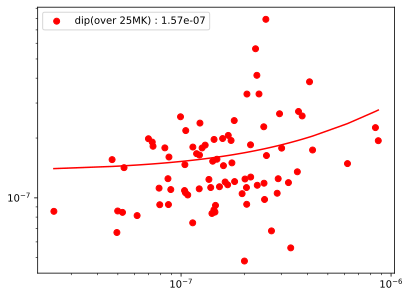

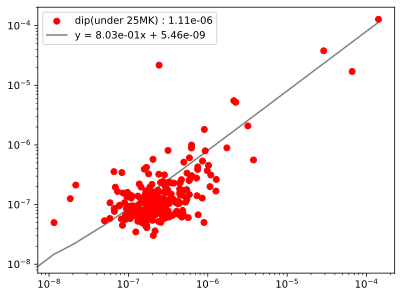

In [77]:
fig, ax = plt.subplots()
res = np.polyfit(dip_over_25_diamag_max,dip_over_25_rotB_max,1)
ax.scatter(dip_over_25_diamag_max,dip_over_25_rotB_max,
           label='dip(over 25MK) : {:.2e}'.format(np.mean(np.abs(dip_over_25_diamag_min))),color='r')
ax.plot(np.sort(dip_over_25_diamag_max),res[0]*np.sort(dip_over_25_diamag_max)+res[1],color='r')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

fig, ax = plt.subplots()
res = np.polyfit(dip_under_25_diamag_max,dip_under_25_rotB_max,1)
ax.scatter(dip_under_25_diamag_max,dip_under_25_rotB_max,
           label='dip(under 25MK) : {:.2e}'.format(np.mean(np.abs(dip_under_25_diamag_min))),color='r')
ax.plot(np.sort(dip_under_25_diamag_max),res[0]*np.sort(dip_under_25_diamag_max)+res[1],color='grey',
        label='y = {:.2e}x + {:.2e}'.format(res[0],res[1]),zorder=0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

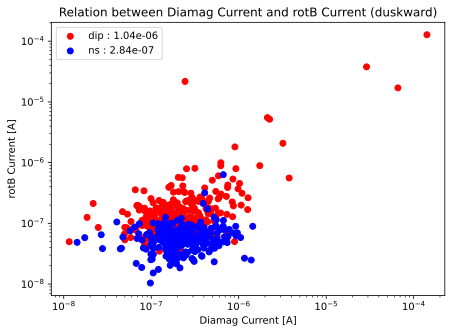

In [89]:
fig, ax = plt.subplots()
ax.scatter(dip_diamag_max,dip_rotB_max,label='dip : {:.2e}'.format(np.mean(np.abs(dip_diamag_max))),color='r')
ax.scatter(ns_diamag_max,ns_rotB_max,label='ns : {:.2e}'.format(np.mean(np.abs(ns_diamag_max))),color='b')
# ax.scatter(none_diamag_max,none_rotB_max,label='none : {:.2e}'.format(np.mean(np.abs(none_diamag_min))),color='g')
ax.set_xlabel('Diamag Current [A]')
ax.set_ylabel('rotB Current [A]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_title('Relation between Diamag Current and rotB Current (duskward)')
plt.tight_layout()
plt.savefig('./figure/Current/diamag_rotB_dawnward.png',dpi=400)

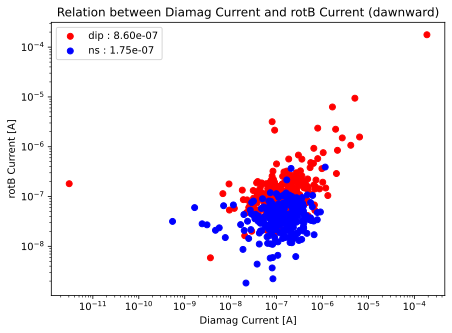

In [90]:
fig, ax = plt.subplots()
ax.scatter(np.abs(dip_diamag_min),np.abs(dip_rotB_min),label='dip : {:.2e}'.format(np.mean(np.abs(dip_diamag_min))),color='r')
ax.scatter(np.abs(ns_diamag_min),np.abs(ns_rotB_min),label='ns : {:.2e}'.format(np.mean(np.abs(ns_diamag_min))),color='b')
# ax.scatter(none_diamag_max,none_rotB_max,label='none : {:.2e}'.format(np.mean(np.abs(none_diamag_min))),color='g')
ax.set_xlabel('Diamag Current [A]')
ax.set_ylabel('rotB Current [A]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_title('Relation between Diamag Current and rotB Current (dawnward)')
plt.tight_layout()
plt.savefig('./figure/Current/diamag_rotB_duskward.png',dpi=400)

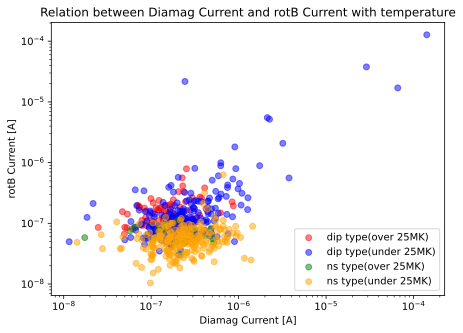

In [91]:
fig, ax = plt.subplots()
ax.scatter(dip_over_25_diamag_max,dip_over_25_rotB_max,label='dip type(over 25MK)',color='red',alpha=0.5)
ax.scatter(dip_under_25_diamag_max,dip_under_25_rotB_max,label='dip type(under 25MK)',color='blue',alpha=0.5)
ax.scatter(ns_over_25_diamag_max,ns_over_25_rotB_max,label='ns type(over 25MK)',color='green',alpha=0.5)
ax.scatter(ns_under_25_diamag_max,ns_under_25_rotB_max,label='ns type(under 25MK)',color='orange',alpha=0.5)

ax.set_xlabel('Diamag Current [A]')
ax.set_ylabel('rotB Current [A]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_title('Relation between Diamag Current and rotB Current with temperature')
plt.tight_layout()
plt.savefig('./figure/Current/diamag_rotB_temp_dawnward.png',dpi=400)

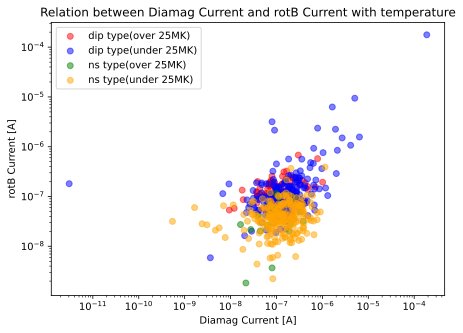

In [92]:
fig, ax = plt.subplots()
ax.scatter(np.abs(dip_over_25_diamag_min),np.abs(dip_over_25_rotB_min),label='dip type(over 25MK)',color='red',alpha=0.5)
ax.scatter(np.abs(dip_under_25_diamag_min),np.abs(dip_under_25_rotB_min),label='dip type(under 25MK)',color='blue',alpha=0.5)
ax.scatter(np.abs(ns_over_25_diamag_min),np.abs(ns_over_25_rotB_min),label='ns type(over 25MK)',color='green',alpha=0.5)
ax.scatter(np.abs(ns_under_25_diamag_min),np.abs(ns_under_25_rotB_min),label='ns type(under 25MK)',color='orange',alpha=0.5)
# ax.scatter(dip_under_25_diamag_max,dip_under_25_rotB_max,label='dip type(under 25MK)',color='blue',alpha=0.5)
# ax.scatter(ns_over_25_diamag_max,ns_over_25_rotB_max,label='ns type(over 25MK)',color='green',alpha=0.5)
# ax.scatter(ns_under_25_diamag_max,ns_under_25_rotB_max,label='ns type(under 25MK)',color='orange',alpha=0.5)

ax.set_xlabel('Diamag Current [A]')
ax.set_ylabel('rotB Current [A]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_title('Relation between Diamag Current and rotB Current with temperature')
plt.tight_layout()
plt.savefig('./figure/Current/diamag_rotB_temp_duskward.png',dpi=400)

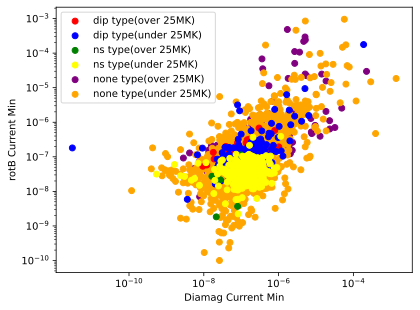

In [ ]:
fig, ax = plt.subplots()
ax.scatter(np.abs(dip_over_25_diamag_min),np.abs(dip_over_25_rotB_min),label='dip type(over 25MK)',color='red',zorder=1)
ax.scatter(np.abs(dip_under_25_diamag_min),np.abs(dip_under_25_rotB_min),label='dip type(under 25MK)',color='blue')
ax.scatter(np.abs(ns_over_25_diamag_min),np.abs(ns_over_25_rotB_min),label='ns type(over 25MK)',color='green')
ax.scatter(np.abs(ns_under_25_diamag_min),np.abs(ns_under_25_rotB_min),label='ns type(under 25MK)',color='yellow')
ax.scatter(np.abs(none_over_25_diamag_min),np.abs(none_over_25_rotB_min),label='none type(over 25MK)',color='purple',zorder=0)
ax.scatter(np.abs(none_under_25_diamag_min),np.abs(none_under_25_rotB_min),label='none type(under 25MK)',color='orange',zorder=0)

ax.set_xlabel('Diamag Current Min')
ax.set_ylabel('rotB Current Min')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

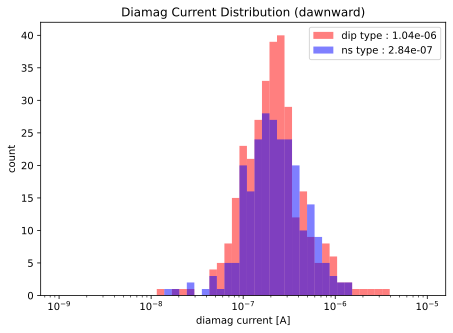

In [99]:
# diamag電流について，ヒストグラムの作成をする
fig, ax = plt.subplots()
ax.hist(dip_diamag_max,bins=np.logspace(-9,-5,50),label='dip type : {:.2e}'.format(np.mean(np.abs(dip_diamag_max))),color='red',alpha=0.5)
ax.hist(ns_diamag_max,bins=np.logspace(-9,-5,50),label='ns type : {:.2e}'.format(np.mean(np.abs(ns_diamag_max))),color='blue',alpha=0.5)
# ax.hist(dip_over_25_diamag_max,bins=np.logspace(-9,-2,50),label='dip type(over 25MK)',color='red',alpha=0.5)
# ax.hist(dip_under_25_diamag_max,bins=np.logspace(-9,-2,50),label='dip type(under 25MK)',color='blue',alpha=0.5)
# ax.hist(ns_over_25_diamag_max,bins=np.logspace(-9,-2,50),label='ns type(over 25MK)',color='green',alpha=0.5)
# ax.hist(ns_under_25_diamag_max,bins=np.logspace(-9,-2,50),label='ns type(under 25MK)',color='yellow',alpha=0.5)
# ax.hist(none_diamag_max,bins=np.logspace(-9,-2,50),label='none type(over 25MK)',color='purple',alpha=0.5)

ax.set_xscale('log')
ax.legend()
ax.set_xlabel('diamag current [A]')
ax.set_ylabel('count')
ax.set_title('Diamag Current Distribution (dawnward)')
plt.tight_layout()
plt.savefig('./figure/Current/diamag_hist_dawnward.png',dpi=400)

# ax.hist(dip_over_25_diamag_max,bins=np.logspace(-38,-2,10),label='dip type(over 25MK)',color='red',alpha=0.5)
# ax.hist(dip_under_25_diamag_max,bins=np.logspace(-38,-2,10),label='dip type(under 25MK)',color='blue',alpha=0.5)


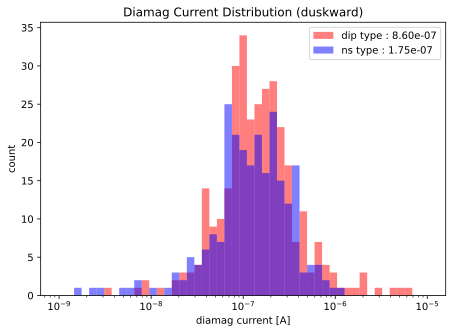

In [100]:
# diamag電流について，ヒストグラムの作成をする
fig, ax = plt.subplots()
ax.hist(np.abs(dip_diamag_min),bins=np.logspace(-9,-5,50),label='dip type : {:.2e}'.format(np.mean(np.abs(dip_diamag_min))),color='red',alpha=0.5)
ax.hist(np.abs(ns_diamag_min),bins=np.logspace(-9,-5,50),label='ns type : {:.2e}'.format(np.mean(np.abs(ns_diamag_min))),color='blue',alpha=0.5)
ax.set_xscale('log')
ax.legend()
ax.set_xlabel('diamag current [A]')
ax.set_ylabel('count')
ax.set_title('Diamag Current Distribution (duskward)')
plt.tight_layout()
plt.savefig('./figure/Current/diamag_hist_duskward.png',dpi=400)

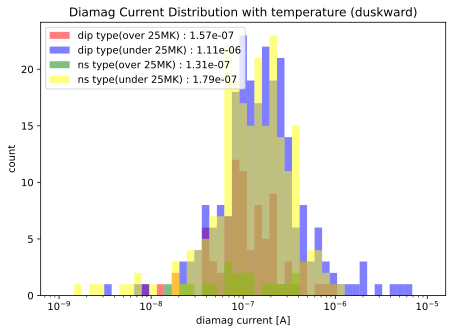

In [104]:
fig, ax = plt.subplots()
ax.hist(np.abs(dip_over_25_diamag_min),bins=np.logspace(-9,-5,50),color='red',alpha=0.5,
        label='dip type(over 25MK) : {:.2e}'.format(np.mean(np.abs(dip_over_25_diamag_min))))
ax.hist(np.abs(dip_under_25_diamag_min),bins=np.logspace(-9,-5,50),color='blue',alpha=0.5,
        label='dip type(under 25MK) : {:.2e}'.format(np.mean(np.abs(dip_under_25_diamag_min))))
ax.hist(np.abs(ns_over_25_diamag_min),bins=np.logspace(-9,-5,50),color='green',alpha=0.5,
        label='ns type(over 25MK) : {:.2e}'.format(np.mean(np.abs(ns_over_25_diamag_min))))
ax.hist(np.abs(ns_under_25_diamag_min),bins=np.logspace(-9,-5,50),color='yellow',alpha=0.5,
        label='ns type(under 25MK) : {:.2e}'.format(np.mean(np.abs(ns_under_25_diamag_min))))
# ax.hist(np.abs(none_diamag_min),bins=np.logspace(-9,-2,50),color='purple',alpha=0.5,
#         label='none type(over 25MK) : {:.2e}'.format(np.mean(np.abs(none_diamag_min))))

ax.set_xscale('log')        
ax.legend()
ax.set_xlabel('diamag current [A]')
ax.set_ylabel('count')
ax.set_title('Diamag Current Distribution with temperature (duskward)')
plt.tight_layout()
plt.savefig('./figure/Current/diamag_hist_temp_duskward.png',dpi=400)

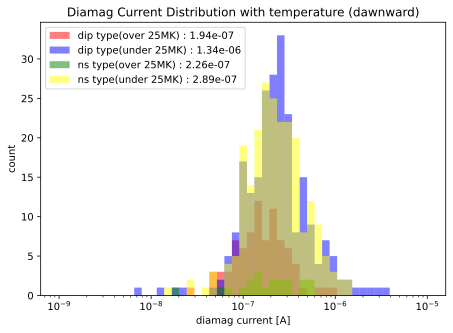

In [105]:
fig, ax = plt.subplots()
ax.hist(np.abs(dip_over_25_diamag_max),bins=np.logspace(-9,-5,50),color='red',alpha=0.5,
        label='dip type(over 25MK) : {:.2e}'.format(np.mean(np.abs(dip_over_25_diamag_max))))
ax.hist(np.abs(dip_under_25_diamag_max),bins=np.logspace(-9,-5,50),color='blue',alpha=0.5,
        label='dip type(under 25MK) : {:.2e}'.format(np.mean(np.abs(dip_under_25_diamag_max))))
ax.hist(np.abs(ns_over_25_diamag_max),bins=np.logspace(-9,-5,50),color='green',alpha=0.5,
        label='ns type(over 25MK) : {:.2e}'.format(np.mean(np.abs(ns_over_25_diamag_max))))
ax.hist(np.abs(ns_under_25_diamag_max),bins=np.logspace(-9,-5,50),color='yellow',alpha=0.5,
        label='ns type(under 25MK) : {:.2e}'.format(np.mean(np.abs(ns_under_25_diamag_max))))
# ax.hist(np.abs(none_diamag_min),bins=np.logspace(-9,-2,50),color='purple',alpha=0.5,
#         label='none type(over 25MK) : {:.2e}'.format(np.mean(np.abs(none_diamag_min))))

ax.set_xscale('log')        
ax.legend()
ax.set_xlabel('diamag current [A]')
ax.set_ylabel('count')
ax.set_title('Diamag Current Distribution with temperature (dawnward)')
plt.tight_layout()
plt.savefig('./figure/Current/diamag_hist_temp_dawnward.png',dpi=400)

(<Figure size 900x300 with 1 Axes>,
 <Axes: title={'center': '2013/06/07 09:03:50 - 2013/06/07 09:13:30'}, xlabel='UTC', ylabel='Magnetic Field [nT]'>)

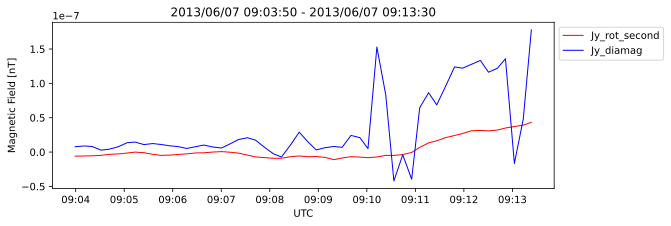

In [39]:
orbit = 201
orbit = 2048

ds = MDUS.dip.query('index == @orbit')['start'].values[0]
de = MDUS.dip.query('index == @orbit')['end'].values[0]
data = MDUS.Datas()
data.Input(orbit=orbit,inputdata=['scan'])
data.scan.DataIntegration()
data.scan.NTP()
data.scan.CalcKTH22(rc=False,ns=False)

data.scan.rotBCurrent()
data.scan.DiamagCurrent()

data.scan.MoveAverage(window=16)

data.scan.PlotMag(component={'Jy_rot_second':'red','Jy_diamag':'blue'},ds=ds,de=de)
# data.scan.value.query('@ds <= index <= @de')

207
ピアソン相関係数: 0.0854048962586985
p値: 0.4601997817870277


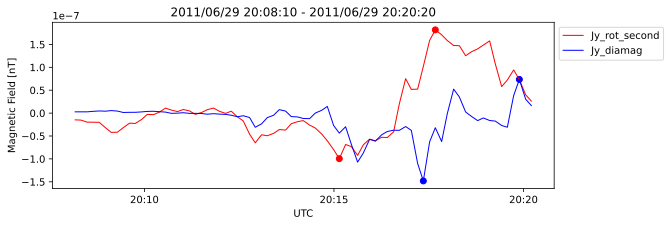

In [71]:
# orbit 199のJy_rot_secondの値とJy_diamagの値の相関を考察する
# 単純にピアソンの相関係数
orbit = 2048
orbit = 201
orbit = 207

ds = MDUS.dip.query('index == @orbit')['start'].values[0]
de = MDUS.dip.query('index == @orbit')['end'].values[0]
data = MDUS.Datas()
data.Input(orbit=orbit,inputdata=['scan'])
data.scan.DataIntegration()
data.scan.NTP()
data.scan.CalcKTH22(rc=False,ns=False)
data.scan.rotBCurrent()
data.scan.DiamagCurrent()
data.scan.MoveAverage(window=16)

diamag = data.scan.value.query('@ds <= index <= @de')['Jy_diamag'].values
rotB = data.scan.value.query('@ds <= index <= @de')['Jy_rot_second'].values

diamag_max = data.scan.value.query('@ds <= index <= @de')['Jy_diamag'].idxmax()
diamag_min = data.scan.value.query('@ds <= index <= @de')['Jy_diamag'].idxmin()
rotB_max = data.scan.value.query('@ds <= index <= @de')['Jy_rot_second'].idxmax()
rotB_min = data.scan.value.query('@ds <= index <= @de')['Jy_rot_second'].idxmin()

corr, p_value = stats.pearsonr(diamag,rotB)
print(orbit)
print("ピアソン相関係数:", corr)
print("p値:", p_value)
fig, ax = data.scan.PlotMag(component={'Jy_rot_second':'red','Jy_diamag':'blue'},ds=ds,de=de)
ax.scatter(diamag_max,data.scan.value.query('index == @diamag_max')['Jy_diamag'],color='blue')
ax.scatter(diamag_min,data.scan.value.query('index == @diamag_min')['Jy_diamag'],color='blue')
ax.scatter(rotB_max,data.scan.value.query('index == @rotB_max')['Jy_rot_second'],color='red')
ax.scatter(rotB_min,data.scan.value.query('index == @rotB_min')['Jy_rot_second'],color='red')

In [69]:
print(dip_over_25)

[  47  196  199  207  209  217  220  395  546  550  587  761  950  970
  971  987  998 1001 1002 1007 1250 1743 1748 1750 1791 1913 1914 1928
 2004 2170 2174 2179 2183 2184 2205 2719 2720 2722 2758 2968 2971 2988
 2989 3006 3237 3239 3241 3245 3246 3252 3256 3493 3502 3503 3510 3511
 3515 3516 3517 3518 3519 3520 3521 3522 3537 3749 3752 3764 3784 3785
 3786 4014 4015 4016 4018 4022 4026 4029 4034 4035 4048 4055]
